In [1]:
import traci
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
# Constants
NUM_PHASES = 3  # Number of traffic light phases
STATE_DIM = 4 # [queue_main, queue_ramp, speed_main, speed_ramp]
ACTION_DIM = NUM_PHASES  # Action space: number of traffic light phases
GAMMA = 0.9  # Discount factor
EPSILON = 0.1  # Exploration rate
ALPHA = 0.001  # Learning rate
MEMORY_CAPACITY = 10000  # Replay memory size
BATCH_SIZE = 32  # Batch size for training
NUM_EPISODES = 100  # Number of training episodes
USE_CONTROL = True  # Set to False for "no control" scenario

# Q-network
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(STATE_DIM,)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(ACTION_DIM, activation="linear"),
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=ALPHA), loss="mse")

# Replay memory
memory = []

# Performance tracking
episode_rewards = []

def get_state():
    """
    Retrieve the current traffic state from SUMO.
    Returns:
        np.array: State vector [queue_main, queue_ramp, speed_main, speed_ramp].
    """
    state = [
        traci.edge.getLastStepHaltingNumber("in"),      # Queue on main road
        traci.edge.getLastStepHaltingNumber("E2"),      # Queue on ramp
        traci.edge.getLastStepMeanSpeed("in"),          # Speed on main road
        traci.edge.getLastStepMeanSpeed("E2"),          # Speed on ramp
    ]
    return np.array(state)

def choose_action(state):
    """
    Choose an action using epsilon-greedy policy.
    Args:
        state (np.array): Current state.
    Returns:
        int: Selected action.
    """
    if np.random.rand() < EPSILON:  # Explore
        return np.random.randint(ACTION_DIM)
    else:  # Exploit
        q_values = model.predict(state.reshape(1, -1), verbose=0)[0]
        return np.argmax(q_values)

def calculate_reward(state, action, next_state):
    """
    Reward function: Minimize halting and maximize speed, with a bonus for speed improvement.
    Args:
        state (np.array): Current state.
        action (int): Action taken.
        next_state (np.array): Next state.
    Returns:
        float: Calculated reward.
    """
    queue_main, queue_ramp, speed_main, speed_ramp = state
    next_speed_main, next_speed_ramp = next_state[2], next_state[3]

    # Base reward: Reduce queue length, increase speed
    reward = -(queue_main + queue_ramp) + (speed_main + speed_ramp)

    # Bonus for speed improvement
    if next_speed_main > speed_main and next_speed_ramp > speed_ramp:
        reward += 5

    return reward

def update_q_network():
    """
    Update the Q-network using a random minibatch from replay memory.
    """
    if len(memory) < BATCH_SIZE:
        return

    # Sample indices manually
    indices = np.random.choice(len(memory), BATCH_SIZE, replace=False)
    minibatch = [memory[i] for i in indices]

    states = np.vstack([transition[0] for transition in minibatch])
    actions = np.array([transition[1] for transition in minibatch])
    rewards = np.array([transition[2] for transition in minibatch])
    next_states = np.vstack([transition[3] for transition in minibatch])
    terminals = np.array([transition[4] for transition in minibatch])

    q_values = model.predict(states, verbose=0)
    next_q_values = model.predict(next_states, verbose=0)

    for i in range(BATCH_SIZE):
        target = rewards[i]
        if not terminals[i]:  # Not terminal state
            target += GAMMA * np.max(next_q_values[i])
        q_values[i, actions[i]] = target

    model.fit(states, q_values, epochs=1, verbose=0)

def check_if_done():
    """
    Termination condition for simulation.
    Returns:
        bool: True if simulation time exceeds 1000 seconds.
    """
    return traci.simulation.getTime() > 1000

# Initialize SUMO
sumo_binary = "sumo-gui"  # Use "sumo" for command-line version
config_file = r"C:\Users\PRO INFORMATIQUE\Desktop\rl\rlprj\projectnet.sumocfg"  # Replace with your SUMO configuration file
traci.start([sumo_binary, "-c", config_file])

# Training loop
# Training loop
for episode in range(NUM_EPISODES):
    state = get_state()
    total_reward = 0

    while traci.simulation.getMinExpectedNumber() > 0:
        # Choose action using epsilon-greedy policy
        action = choose_action(state)

        # Apply the chosen action to the traffic light in SUMO
        traci.trafficlight.setPhase("n6", action)

        # Step the simulation (allowing the change to take effect)
        traci.simulationStep()

        # Obtain the next state
        next_state = get_state()

        # Calculate reward
        reward = calculate_reward(state, action, next_state)

        # Check if the simulation is done
        done = check_if_done()

        # Store the transition in the replay memory
        memory.append((state, action, reward, next_state, done))
        if len(memory) > MEMORY_CAPACITY:
            memory.pop(0)

        # Update the Q-network
        update_q_network()

        # Update the current state
        state = next_state
        total_reward += reward

        # If the episode is done, break out of the simulation loop
        if done:
            break

    episode_rewards.append(total_reward)  # Append the total reward for the episode to the list

    # Print summary after each episode
    print(f"Episode {episode + 1}/{NUM_EPISODES}, Total Reward: {total_reward}")

# Save the model after training
model.save("trained_traffic_light_model_ql.h5")
print("Model saved successfully.")

# Close SUMO connection
traci.close()


Episode 1/100, Total Reward: 21090.391618337213
Episode 2/100, Total Reward: 43.89
Episode 3/100, Total Reward: 43.89
Episode 4/100, Total Reward: 43.89
Episode 5/100, Total Reward: 43.89
Episode 6/100, Total Reward: 43.89
Episode 7/100, Total Reward: 43.89
Episode 8/100, Total Reward: 43.89
Episode 9/100, Total Reward: 43.89
Episode 10/100, Total Reward: 43.89
Episode 11/100, Total Reward: 43.89
Episode 12/100, Total Reward: 43.89
Episode 13/100, Total Reward: 43.89
Episode 14/100, Total Reward: 43.89
Episode 15/100, Total Reward: 43.89
Episode 16/100, Total Reward: 43.89
Episode 17/100, Total Reward: 43.89
Episode 18/100, Total Reward: 43.89
Episode 19/100, Total Reward: 43.89
Episode 20/100, Total Reward: 43.89
Episode 21/100, Total Reward: 43.89
Episode 22/100, Total Reward: 43.89
Episode 23/100, Total Reward: 43.89
Episode 24/100, Total Reward: 43.89
Episode 25/100, Total Reward: 43.89
Episode 26/100, Total Reward: 43.89
Episode 27/100, Total Reward: 43.89
Episode 28/100, Total Re

Episode 100/100, Total Reward: 42.0
Model saved successfully.


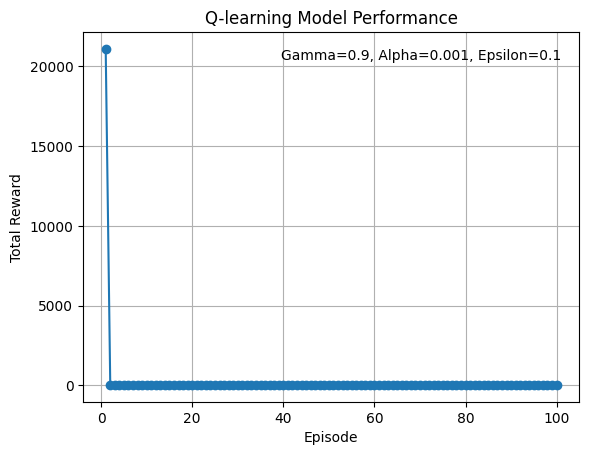

In [3]:
# Plot the episode rewards
plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)
# Add a legend with hyperparameter values
hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}, Epsilon={EPSILON}'
plt.text(NUM_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()